<a href="https://colab.research.google.com/github/JoshuaOgbe/JoshuaOgbe/blob/main/Time_Series_Predict_Number_of_Visitors_to_a_Restaurant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Summary

We are a consulting firm, "Power Panthers Corps," and we are trying to help restuarants in Japan, who have purchased AirREGI, a reservation and control cash system. We are interested in predicting the number of visitors who have attended resaurants and if the number of visitors fluctuates over the day of the week, month, year, and holidays.
Additionally, we would like to see how the number of visitors fluctuates over a single day. Do more visitors come at 7 pm or 8 pm? If visitors come at 8 pm, does that influence how many come at 9 pm? 
One imperative thing to note, is that based on our data, we are only able to see the time a customer visited the restaurant, based on a csv file, air_reserve.csv, which contains a file of the air reservation visit time. Therefore, going forward, we will be looking at restuarant visitors as assumed by their reservation through this air reservation system. We acknowledge that, going forward this way, may lead to gaps in our analysis: there could be many restaurants where a visitor attendance is not reserved/recorded through the air reservation system (i.e a customer just walks in/drops without reserving a table in the system or a hostess doesn't record the group on the app). But, based on the csv info we have, we have to use this reservation system as our way of analyzing the number of restaurant visitors over time and over the hours of a day. 


2. Cleaning and graphinh (time series) the Month to Month Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
#import lightgbm as lgb
import matplotlib.pyplot as plt

In [ ]:
air_reserve_1 = pd.read_csv('air_reserve_1.csv')
air_reserve_1.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,1/1/2016 19:00,1/1/2016 16:00,1
1,air_db4b38ebe7a7ceff,1/1/2016 19:00,1/1/2016 19:00,3
2,air_db4b38ebe7a7ceff,1/1/2016 19:00,1/1/2016 19:00,6
3,air_877f79706adbfb06,1/1/2016 20:00,1/1/2016 16:00,2
4,air_db80363d35f10926,1/1/2016 20:00,1/1/2016 1:00,5


In [ ]:
#air_reserve_datafram cleaning:
#this is the air_resrve data, it has the restuarant id, the time of VISIT, date of VISIT scheduled in the reservation, and hour of VISIT reservation: 
#restaurant_ids can be redundant here

air_reserve_1 = pd.read_csv('air_reserve_1.csv')
air_reserve_1['visit_datetime'] = pd.to_datetime(air_reserve_1['visit_datetime'])
air_reserve_1['visit_date'] = air_reserve_1['visit_datetime'].dt.date
air_reserve_1['visit_datetime'] = pd.to_datetime(air_reserve_1['visit_datetime'])
air_reserve_1['dow'] = air_reserve_1['visit_datetime'].dt.dayofweek
air_reserve_1['year'] = air_reserve_1['visit_datetime'].dt.year
air_reserve_1['month'] = air_reserve_1['visit_datetime'].dt.month
air_reserve_1['visit_date'] = air_reserve_1['visit_datetime'].dt.date

air_reserve_1['visit_hour'] = air_reserve_1['visit_datetime'].dt.hour
air_reserve_1 = air_reserve_1.drop(['reserve_datetime'], axis=1)
air_reserve_1 = air_reserve_1.drop(['visit_datetime'], axis=1)
air_reserve_1.head(5)

,air_store_id,reserve_visitors,visit_date,dow,year,month,visit_hour
0,air_877f79706adbfb06,1,2016-01-01,4,2016,1,19
1,air_db4b38ebe7a7ceff,3,2016-01-01,4,2016,1,19
2,air_db4b38ebe7a7ceff,6,2016-01-01,4,2016,1,19
3,air_877f79706adbfb06,2,2016-01-01,4,2016,1,20
4,air_db80363d35f10926,5,2016-01-01,4,2016,1,20


2. Creating data to do a monthly analysis. Note: Sunday = 1,Sunday = 7.....

In [ ]:
#now lets group by the number of visitors per store id and per day and find the trends over the months  (air_reserve_mtm => air_reserve month to month)

In [ ]:
air_reserve_mtm=air_reserve_1.groupby(['air_store_id','visit_date', "dow", 'year', 'month'])['reserve_visitors'].sum().reset_index()

In [ ]:
air_reserve_mtm.head()

,air_store_id,visit_date,dow,year,month,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2016,10,2
1,air_00a91d42b08b08d9,2016-12-05,0,2016,12,9
2,air_00a91d42b08b08d9,2016-12-14,2,2016,12,18
3,air_00a91d42b08b08d9,2016-12-17,5,2016,12,2
4,air_00a91d42b08b08d9,2016-12-20,1,2016,12,4


In [ ]:
#create unique id column
air_reserve_mtm['unique_id'] = air_reserve_mtm['air_store_id'].map(str) + '-' + air_reserve_mtm['visit_date'].map(str)

In [ ]:
air_reserve_mtm.head()


,air_store_id,visit_date,dow,year,month,reserve_visitors,unique_id
0,air_00a91d42b08b08d9,2016-10-31,0,2016,10,2,air_00a91d42b08b08d9-2016-10-31
1,air_00a91d42b08b08d9,2016-12-05,0,2016,12,9,air_00a91d42b08b08d9-2016-12-05
2,air_00a91d42b08b08d9,2016-12-14,2,2016,12,18,air_00a91d42b08b08d9-2016-12-14
3,air_00a91d42b08b08d9,2016-12-17,5,2016,12,2,air_00a91d42b08b08d9-2016-12-17
4,air_00a91d42b08b08d9,2016-12-20,1,2016,12,4,air_00a91d42b08b08d9-2016-12-20


In [ ]:
pd.Series( air_reserve_mtm["unique_id"]).is_unique

True

In [ ]:
air_reserve_mtm

,air_store_id,visit_date,dow,year,month,reserve_visitors,unique_id
0,air_00a91d42b08b08d9,2016-10-31,0,2016,10,2,air_00a91d42b08b08d9-2016-10-31
1,air_00a91d42b08b08d9,2016-12-05,0,2016,12,9,air_00a91d42b08b08d9-2016-12-05
2,air_00a91d42b08b08d9,2016-12-14,2,2016,12,18,air_00a91d42b08b08d9-2016-12-14
3,air_00a91d42b08b08d9,2016-12-17,5,2016,12,2,air_00a91d42b08b08d9-2016-12-17
4,air_00a91d42b08b08d9,2016-12-20,1,2016,12,4,air_00a91d42b08b08d9-2016-12-20
...,...,...,...,...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,5,2017,4,2,air_fea5dc9594450608-2017-04-22
29826,air_fea5dc9594450608,2017-04-25,1,2017,4,2,air_fea5dc9594450608-2017-04-25
29827,air_fea5dc9594450608,2017-04-28,4,2017,4,3,air_fea5dc9594450608-2017-04-28
29828,air_fea5dc9594450608,2017-05-20,5,2017,5,6,air_fea5dc9594450608-2017-05-20


In [ ]:
#airstore info 
air_store_info = pd.read_csv('air_store_info_1.csv')
air_store_info.head()


air_reserve_mtm= pd.merge(air_reserve_mtm, air_store_info, how = 'inner', on = ['air_store_id'])

In [ ]:
air_reserve_mtm.head()

,air_store_id,visit_date,dow,year,month,reserve_visitors,unique_id,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,2016-10-31,0,2016,10,2,air_00a91d42b08b08d9-2016-10-31,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_00a91d42b08b08d9,2016-12-05,0,2016,12,9,air_00a91d42b08b08d9-2016-12-05,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
2,air_00a91d42b08b08d9,2016-12-14,2,2016,12,18,air_00a91d42b08b08d9-2016-12-14,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
3,air_00a91d42b08b08d9,2016-12-17,5,2016,12,2,air_00a91d42b08b08d9-2016-12-17,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
4,air_00a91d42b08b08d9,2016-12-20,1,2016,12,4,air_00a91d42b08b08d9-2016-12-20,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595


In [ ]:
data_info = pd.read_csv('data_info.csv')
data_info = data_info.rename(columns ={'calendar_date': 'visit_date'})
data_info.head()

,visit_date,day_of_week,holiday_flg
0,1/1/2016,Friday,1
1,1/2/2016,Saturday,1
2,1/3/2016,Sunday,1
3,1/4/2016,Monday,0
4,1/5/2016,Tuesday,0


In [ ]:
data_info['visit_date'] = pd.to_datetime(data_info.visit_date, format='%m/%d/%Y')

data_info['visit_date'] = data_info['visit_date'].dt.strftime('%Y-%m-%d')

In [ ]:
data_info.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [ ]:
air_reserve_mtm.head()
air_reserve_mtm['visit_date'] = pd.to_datetime(air_reserve_mtm.visit_date, format='%Y/%m/%d')

air_reserve_mtm['visit_date'] = air_reserve_mtm['visit_date'].dt.strftime('%Y-%m-%d')

In [ ]:
air_reserve_mtm= pd.merge(air_reserve_mtm, data_info, on= "visit_date", how="inner")

In [ ]:
#josh this is what you want to use for clustering!

air_reserve_mtm.head(5)

,air_store_id,visit_date,dow,year,month,reserve_visitors,unique_id,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_00a91d42b08b08d9,2016-10-31,0,2016,10,2,air_00a91d42b08b08d9-2016-10-31,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Monday,0
1,air_03963426c9312048,2016-10-31,0,2016,10,12,air_03963426c9312048-2016-10-31,Izakaya,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,Monday,0
2,air_04cae7c1bc9b2a0b,2016-10-31,0,2016,10,13,air_04cae7c1bc9b2a0b-2016-10-31,Izakaya,Hokkaidō Sapporo-shi Kotoni 2 Jō,43.074470,141.300889,Monday,0
3,air_0867f7bebad6a649,2016-10-31,0,2016,10,2,air_0867f7bebad6a649-2016-10-31,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,Monday,0
4,air_08cb3c4ee6cd6a22,2016-10-31,0,2016,10,20,air_08cb3c4ee6cd6a22-2016-10-31,Izakaya,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,34.756950,134.841177,Monday,0


In [ ]:
#DONE, now convert csv

In [ ]:
air_reserve_mtm.to_csv("air_reserve_weeks_months.csv")

In [ ]:
#rolling up the visitors into months

In [ ]:
air_reserve_mtm_tsdata=air_reserve_1.groupby([ 'year', 'month'])['reserve_visitors'].sum().reset_index()

In [ ]:
air_reserve_mtm_tsdata.head(20)

,year,month,reserve_visitors
0,2016,1,10335
1,2016,2,11579
2,2016,3,17071
3,2016,4,13811
4,2016,5,8385
5,2016,6,4590
6,2016,7,4603
7,2016,8,2
8,2016,9,12
9,2016,10,7854


In [ ]:
air_reserve_mtm_tsdata['month-year'] = pd.to_datetime(air_reserve_mtm_tsdata[['month', 'year']].assign(Day=1))

In [ ]:
sns.set(rc={"figure.figsize":(20, 4)})
sns.lineplot(x="month-year", y="reserve_visitors",data=air_reserve_mtm_tsdata)

plt.show()

In [ ]:
#Megha- this is where we need to add the sum of the visitors per week
#start with air_reserve_mtm dataframe and add week 1 thru 52 depending on the date
#we could also look at the daily time series analysis if we wanted to to a time series analysis with just the total number of 
#visitors per day in the years jan 2016-may 2017 (you'd start with air_reserve_mtm data frame and go from there aquire the days)


3. Overview of hourly analysis and hourly analysis based on day of the week

In [ ]:
air_reserve_hth=air_reserve_1.groupby(['air_store_id','visit_hour', "dow"])['reserve_visitors'].sum().reset_index()

In [ ]:
air_reserve_hth.head()

,air_store_id,visit_hour,dow,reserve_visitors
0,air_00a91d42b08b08d9,17,1,3
1,air_00a91d42b08b08d9,17,4,2
2,air_00a91d42b08b08d9,18,5,9
3,air_00a91d42b08b08d9,19,0,9
4,air_00a91d42b08b08d9,19,1,6


In [ ]:
air_reserve_hth['unique_id'] = air_reserve_hth['air_store_id'].map(str) + '-' + air_reserve_hth['visit_hour'].map(str) + '-' + air_reserve_hth['dow'].map(str)

In [ ]:
air_reserve_hth.head()

,air_store_id,visit_hour,dow,reserve_visitors,unique_id
0,air_00a91d42b08b08d9,17,1,3,air_00a91d42b08b08d9-17-1
1,air_00a91d42b08b08d9,17,4,2,air_00a91d42b08b08d9-17-4
2,air_00a91d42b08b08d9,18,5,9,air_00a91d42b08b08d9-18-5
3,air_00a91d42b08b08d9,19,0,9,air_00a91d42b08b08d9-19-0
4,air_00a91d42b08b08d9,19,1,6,air_00a91d42b08b08d9-19-1


In [ ]:
pd.Series( air_reserve_hth["unique_id"]).is_unique

True

In [ ]:
#airstore info 
air_store_info = pd.read_csv('air_store_info_1.csv')
air_store_info.head()


air_reserve_hth= pd.merge(air_reserve_hth, air_store_info, how = 'inner', on = ['air_store_id'])

In [ ]:
air_reserve_hth.head()

,air_store_id,visit_hour,dow,reserve_visitors,unique_id,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,17,1,3,air_00a91d42b08b08d9-17-1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_00a91d42b08b08d9,17,4,2,air_00a91d42b08b08d9-17-4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
2,air_00a91d42b08b08d9,18,5,9,air_00a91d42b08b08d9-18-5,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
3,air_00a91d42b08b08d9,19,0,9,air_00a91d42b08b08d9-19-0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
4,air_00a91d42b08b08d9,19,1,6,air_00a91d42b08b08d9-19-1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595


In [ ]:
air_reserve_hth.to_csv("air_reserve_hth.csv")

In [ ]:
 #EDA for hth/dow

In [ ]:
air_reserve_hth.head()

,air_store_id,visit_hour,dow,reserve_visitors,unique_id,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,17,1,3,air_00a91d42b08b08d9-17-1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_00a91d42b08b08d9,17,4,2,air_00a91d42b08b08d9-17-4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
2,air_00a91d42b08b08d9,18,5,9,air_00a91d42b08b08d9-18-5,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
3,air_00a91d42b08b08d9,19,0,9,air_00a91d42b08b08d9-19-0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
4,air_00a91d42b08b08d9,19,1,6,air_00a91d42b08b08d9-19-1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595


In [ ]:
#grouping by day of the week
air_reserve_hour_group_by=air_reserve_hth.groupby([ "dow"])['reserve_visitors'].sum().reset_index()

In [ ]:
air_reserve_hour_group_by.dtypes

dow                 int64
reserve_visitors    int64
dtype: object

In [ ]:
air_reserve_hour_group_by['dow']=air_reserve_hour_group_by['dow'].astype(np.object)

C:\Users\myand\AppData\Local\Temp/ipykernel_16052/2607190776.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  air_reserve_hour_group_by['dow']=air_reserve_hour_group_by['dow'].astype(np.object)


In [ ]:
air_reserve_hour_group_by

,dow,reserve_visitors
0,0,36065
1,1,42938
2,2,52341
3,3,54538
4,4,92565
5,5,91943
6,6,43625


In [ ]:
air_reserve_hour_group_by['dow'] = air_reserve_hour_group_by['dow'].map({0: 'Monday' , 1: 'Tuesday', 2: 'Wednesday',3:'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})


In [ ]:
air_reserve_hour_group_by

,dow,reserve_visitors
0,Monday,36065
1,Tuesday,42938
2,Wednesday,52341
3,Thursday,54538
4,Friday,92565
5,Saturday,91943
6,Sunday,43625


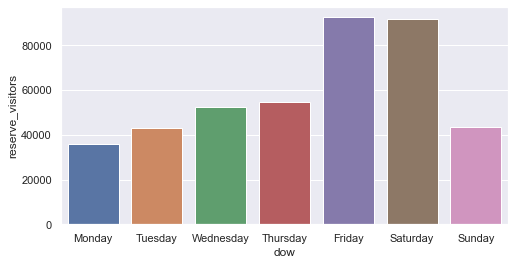

In [ ]:
import seaborn as sns

sns.set(rc={"figure.figsize":(8, 4)})
sns.barplot(x="dow", y="reserve_visitors", data=air_reserve_hour_group_by)

plt.show()

In [ ]:
#lets order air_reserve_mtm by months

In [ ]:
#hour by hour distribution of hours

In [ ]:
air_reserve_hth.head()

,air_store_id,visit_hour,dow,reserve_visitors,unique_id,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,17,1,3,air_00a91d42b08b08d9-17-1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_00a91d42b08b08d9,17,4,2,air_00a91d42b08b08d9-17-4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
2,air_00a91d42b08b08d9,18,5,9,air_00a91d42b08b08d9-18-5,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
3,air_00a91d42b08b08d9,19,0,9,air_00a91d42b08b08d9-19-0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
4,air_00a91d42b08b08d9,19,1,6,air_00a91d42b08b08d9-19-1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595


In [ ]:
#grouping by day of the week
air_reserve_hourbyhour_group_by=air_reserve_hth.groupby([ "visit_hour"])['reserve_visitors'].sum().reset_index()

In [ ]:
air_reserve_hourbyhour_group_by['visit_hour']=air_reserve_hourbyhour_group_by['visit_hour'].astype(np.object)

C:\Users\myand\AppData\Local\Temp/ipykernel_16052/2305850720.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  air_reserve_hourbyhour_group_by['visit_hour']=air_reserve_hourbyhour_group_by['visit_hour'].astype(np.object)


In [ ]:
 air_reserve_hourbyhour_group_by['visit_hour'] = air_reserve_hourbyhour_group_by['visit_hour'].map({0: '12 am' , 1: '1 am', 2: '2 am',3:'3 am', 4: '4 am', 5: '5 am', 6: '6 am', 7: '7 am' , 8: '8 am', 9: '9 am',10:'10 am', 11: '11 am', 12: '12 pm',13: '1 pm', 14: '2 pm',15:'3 pm', 16: '4pm', 17: '5 pm', 18: '6 pm',19: '7 pm' , 20: '8 pm', 21: '9 pm',22:'10 pm', 23: '11 pm'})


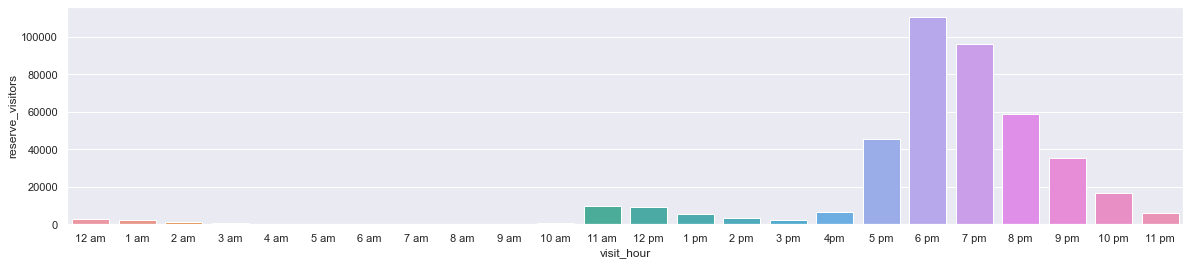

In [ ]:
import seaborn as sns

sns.set(rc={"figure.figsize":(20, 4)})
sns.barplot(x="visit_hour", y="reserve_visitors",data=air_reserve_hourbyhour_group_by)

plt.show()

In [ ]:
air_reserve_mtm

,air_store_id,visit_date,dow,year,month,reserve_visitors,unique_id,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_00a91d42b08b08d9,2016-10-31,0,2016,10,2,air_00a91d42b08b08d9-2016-10-31,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Monday,0
1,air_03963426c9312048,2016-10-31,0,2016,10,12,air_03963426c9312048-2016-10-31,Izakaya,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,Monday,0
2,air_04cae7c1bc9b2a0b,2016-10-31,0,2016,10,13,air_04cae7c1bc9b2a0b-2016-10-31,Izakaya,Hokkaidō Sapporo-shi Kotoni 2 Jō,43.074470,141.300889,Monday,0
3,air_0867f7bebad6a649,2016-10-31,0,2016,10,2,air_0867f7bebad6a649-2016-10-31,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,Monday,0
4,air_08cb3c4ee6cd6a22,2016-10-31,0,2016,10,20,air_08cb3c4ee6cd6a22-2016-10-31,Izakaya,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,34.756950,134.841177,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29825,air_ab9746a0f83084b7,2016-09-05,0,2016,9,2,air_ab9746a0f83084b7-2016-09-05,Cafe/Sweets,Tōkyō-to Setagaya-ku Okusawa,35.602125,139.671958,Monday,0
29826,air_a546cbf478a8b6e4,2016-09-16,4,2016,9,2,air_a546cbf478a8b6e4-2016-09-16,Yakiniku/Korean food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Friday,0
29827,air_a546cbf478a8b6e4,2016-10-06,3,2016,10,5,air_a546cbf478a8b6e4-2016-10-06,Yakiniku/Korean food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Thursday,0
29828,air_aed3a8b49abe4a48,2016-09-12,0,2016,9,2,air_aed3a8b49abe4a48-2016-09-12,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōgimachi,34.705362,135.510025,Monday,0


In [ ]:
air_reserve_mtm

,air_store_id,visit_date,dow,year,month,reserve_visitors,unique_id,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_00a91d42b08b08d9,2016-10-31,0,2016,10,2,air_00a91d42b08b08d9-2016-10-31,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Monday,0
1,air_03963426c9312048,2016-10-31,0,2016,10,12,air_03963426c9312048-2016-10-31,Izakaya,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,Monday,0
2,air_04cae7c1bc9b2a0b,2016-10-31,0,2016,10,13,air_04cae7c1bc9b2a0b-2016-10-31,Izakaya,Hokkaidō Sapporo-shi Kotoni 2 Jō,43.074470,141.300889,Monday,0
3,air_0867f7bebad6a649,2016-10-31,0,2016,10,2,air_0867f7bebad6a649-2016-10-31,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,Monday,0
4,air_08cb3c4ee6cd6a22,2016-10-31,0,2016,10,20,air_08cb3c4ee6cd6a22-2016-10-31,Izakaya,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,34.756950,134.841177,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29825,air_ab9746a0f83084b7,2016-09-05,0,2016,9,2,air_ab9746a0f83084b7-2016-09-05,Cafe/Sweets,Tōkyō-to Setagaya-ku Okusawa,35.602125,139.671958,Monday,0
29826,air_a546cbf478a8b6e4,2016-09-16,4,2016,9,2,air_a546cbf478a8b6e4-2016-09-16,Yakiniku/Korean food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Friday,0
29827,air_a546cbf478a8b6e4,2016-10-06,3,2016,10,5,air_a546cbf478a8b6e4-2016-10-06,Yakiniku/Korean food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Thursday,0
29828,air_aed3a8b49abe4a48,2016-09-12,0,2016,9,2,air_aed3a8b49abe4a48-2016-09-12,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōgimachi,34.705362,135.510025,Monday,0


4. Clustering modeling: 
See R Studio code

5. Poisson, Negative binomial modeling:
See R studio code